# Chapter 11 - I2VIS

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

In [13]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf

include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")

using PyPlot

In [14]:
# Define a function to form the energy equation left hand side and right hand side
function assemble_energy_equation_center(grid::CartesianGrid,rho::Matrix,Cp::Matrix,kThermal::Matrix,H::Matrix,Tlast::Matrix,dt)
    bcleft  = -1   # -1 = insulating, 1 = constant temp
    bcright = -1   #
    bctop   =  1
    bcbottom  = 1
    bcval = [0.0,0.0,1000.0,1000.0] # left,right,top,bottom
    
    N = grid.nx*grid.ny
    row = zeros(Int64,5*N);
    col = zeros(Int64,5*N);
    val = zeros(Float64, 5*N);
    R = zeros(Float64,N,1);
    k = 1;
    #        j-1   j     j   j+1   j+1
    #   i-1   |----kC----|----vy----|
    #         |          |          |
    #   i     kA    T   kB    T     |
    #         |          |          |
    #   i     |----kD--(i,j)--vy----|
    #         |          |          |
    #   i+1   vx    c    vx   c     vx
    #         |          |          |
    #   i+1   |----vy----|----vy----|
    
    for j in 1:grid.nx
        dxc = j>1 ? grid.x[j] - grid.x[j-1] : grid.x[j+1] - grid.x[j]
        dxp = grid.xc[j+1] - grid.xc[j]
        dxm = j>1 ? grid.xc[j]-grid.xc[j-1] : grid.xc[j+1] - grid.xc[j]
        for i in 1:grid.ny
            dyc = i>1 ? grid.y[i] - grid.y[i-1] : grid.y[i+1] - grid.y[i]
            dyp = grid.yc[i+1] - grid.yc[i]
            dym = i>1 ? grid.yc[i]-grid.yc[i-1] : grid.yc[i+1] - grid.yc[i]
            
            this_row = node_index(i,j,grid.ny);
            if i==1 # ghost nodes along top.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i+1,j,grid.ny)
                val[k] = bctop/2.0
                k+=1
                
                R[this_row] = bcval[3]
            elseif j==1 # ghost nodes along left side.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i,j+1,grid.ny)
                val[k] = bcleft/2.0
                k+=1
                
                R[this_row] = bcval[1]
            else            
                # kA, kB, kC, kD
                kA = 0.5*(kThermal[i-1,j-1] + kThermal[i,j-1])
                kB = 0.5*(kThermal[i,j]     + kThermal[i-1,j])
                kC = 0.5*(kThermal[i-1,j-1] + kThermal[i-1,j])
                kD = 0.5*(kThermal[i,j-1]   + kThermal[i,j])
                rho_c = 0.25*(rho[i-1,j-1] + rho[i,j-1] + rho[i-1,j] + rho[i,j])
                Cp_c = 0.25*(Cp[i-1,j-1] + Cp[i,j-1] + Cp[i-1,j] + Cp[i,j])

                # diagonal entry
                row[k] = this_row;
                col[k] = this_row;
                val[k] = (rho_c*Cp_c)/dt + kB/dxp/dxc + kA/dxm/dxc + kD/dyp/dyc + kC/dyp/dyc;
                k+=1
                # right
                row[k] = this_row;
                col[k] = j==grid.nx ? node_index(i,j,grid.ny) : node_index(i,j+1,grid.ny);
                val[k] = j==grid.nx ? bcright*kB/dxp/dxc : -kB/dxp/dxc;
                k+=1
                # left
                row[k] = this_row;
                col[k] = node_index(i,j-1,grid.ny);
                val[k] = -kA/dxm/dxc;
                k+=1
                # down (+y)
                row[k] = this_row;
                col[k] = i==grid.ny ? node_index(i,j,grid.ny) : node_index(i+1,j,grid.ny);
                val[k] = i==grid.ny ? bcbottom*kD/dyp/dyc : -kD/dyp/dyc;
                k+=1
                # up (-y)
                row[k] = this_row;
                col[k] = node_index(i-1,j,grid.ny);
                val[k] = -kC/dyp/dyc;
                k+=1
                
                R[this_row] = Tlast[i,j]*rho_c*Cp_c/dt;
                if j==grid.nx
                    R[this_row] += 2*bcval[2]*bcright*kB/dxp/dxc
                end
                if i==grid.ny
                    R[this_row] += 2*bcval[4]*bcbottom*kD/dyp/dyc
                end
            end
        end
    end
    row = @views row[1:k-1]
    col = @views col[1:k-1]
    val = @views val[1:k-1]
    L = sparse(row,col,val)
    return L,R
end

function ghost_temperature(grid::CartesianGrid,T::Matrix{Float64})
    # Define a new grid that is (ny+1)x(nx+1) and insert the ghost temperature values.
    bcleft  = -1   # -1 = insulating, 1 = constant temp
    bcright = -1   #
    bctop   =  1
    bcbottom  = 1
    bcval = [0.0,0.0,1000.0,1000.0] # left,right,top,bottom
    Tpad = Array{Float64,2}(undef,grid.ny+1,grid.nx+1)
    Tpad[1:grid.ny,1:grid.nx] = T[1:grid.ny,1:grid.nx]
    # right side first
    for i in 1:grid.ny
        if bcright == 1
             Tpad[i,grid.nx+1] = 2.0*bcval[2]-Tpad[i,grid.nx]
        elseif bcright == -1
            Tpad[i,grid.nx+1] = Tpad[i,grid.nx]
        end
    end
    # bottom
    for j in 1:grid.nx+1
        if bcbottom == 1
            Tpad[grid.ny+1,j] = 2.0*bcval[4]-Tpad[grid.ny,j]
        elseif bcbottom == -1
            Tpad[grid.ny+1,j] = Tpad[grid.ny,j]
        end
    end
    return Tpad
end

function subgrid_temperature_relaxation!(markers::Markers,grid::CartesianGrid,Tlast::Matrix,Cp,kThermal,dt::Float64)
        dsubgrid = 1.0; # subgrid temperature diffusivity
        dT_subgrid_m = Array{Float64,2}(undef,1,markers.nmark)
        # compuate the nodal temperature on the markers.    
        cell_center_to_markers!(markers,grid,Tlast,dT_subgrid_m)
    
        # compute the subgrid temperature changes on the markers
        rho = markers.scalarFields["rho"]
        T = markers.scalarFields["T"]
        Threads.@threads for i in 1:markers.nmark
            dx2 = (grid.x[markers.cell[1,i]+1] - grid.x[markers.cell[1,i]])^2
            dy2 = (grid.y[markers.cell[2,i]+1] - grid.y[markers.cell[2,i]])^2
            tdiff = markers.scalars[rho,i]*Cp/kThermal / (2/dx2 + 2/dy2)
            dT_subgrid_m[i] = (dT_subgrid_m[i]-markers.scalars[T,i])*( 1.0 - exp(-dsubgrid*dt/tdiff) )
        end
        # interpolate subgrid temperature changes back onto basic nodes.
        markers.scalars[T,1:markers.nmark] += dT_subgrid_m[1,:]
        dTm, = marker_to_stag(markers,grid,dT_subgrid_m,"center")
        return dTm
end

function initial_conditions!(markers::Markers)
    rho = markers.scalarFields["rho"]
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        # my initial misunderstanding of the problem setup:
        # markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
        markers.scalars[rho,i] = mr < 1.0e5 ? 3200. : 3300.
        markers.scalars[eta,i] = mr < 1.0e5 ? 1e20 : 1e21 
        markers.scalars[T,i] = mr < 1.0e5 ? 1300. : 1000.
    end
end

function visualization(grid::CartesianGrid,rho::Matrix,eta::Matrix,vn::Array{Float64},pressure::Matrix,temperature::Matrix,time ; filename="test.vts")
    # write the visualization output from the regular grid as a .vts file.
    vtk_grid(filename, grid.x, grid.y) do vtk
        vtk["rho"] = transpose(rho)
        vtk["viscosity"] = transpose(eta)
        # add a fake third dimension to the velocity vectors
        v3 = Array{Float64,3}(undef,3,grid.nx,grid.ny)
        v3[1:2,:,:] = vn
        v3[3,:,:] .= 0.0
        vtk["Velocity"] = v3
        vtk["Temperature"] = transpose(temperature)
        vtk["pressure"] = transpose(pressure[2:end,2:end])
        vtk["TIME"] = time
    end
end

function visualization(markers::Markers,time; filename="markers.vtp")  
    p3 = Array{Float64,2}(undef,3,markers.nmark)
    p3[1:2,:] = markers.x[1:2,1:markers.nmark]
    p3[3,:] .= 0.0
      
    polys = [MeshCell(PolyData.Polys(),i:i) for i in 1:markers.nmark]
    vtk_grid(filename,p3,polys) do vtk    
        for key in keys(markers.scalarFields)
            vtk[key] = markers.scalars[markers.scalarFields[key],1:markers.nmark]
        end
       vtk["TimeValue"] = time
    end
end

visualization (generic function with 2 methods)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat step 4.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 2nd order Runge-Kutta

In [18]:
function run(nstep::Int64)
    nx = 201
    ny = 201
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0

    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.

    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 1e5*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);
    # fill!(rho,3200.);
    # fill!(kThermal,3.0);
    # fill!(Cp,1000.);

    time = 0.0
    iout=0
    last_plot = 0.0


    local rho
    local rhox
    local rhoy
    local eta_s
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast

    output_dir = "ch11_subgrid"
    for itime in 1:nstep
        # Get density and viscosity from the markers.
        rho_new,eta_s_new = marker_to_stag(markers,grid,["rho","eta"],"basic");
        rhox_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rhoy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        
        if time > 0.0
            nanind = findall(isnan.(rho_new))
            rho_new[nanind] = rho[nanind]
            eta_s_new[nanind] = eta_s[nanind] 
            nanind = findall(isnan.(rhox_new))
            rhox_new[nanind] = rhox[nanind]
            nanind = findall(isnan.(rhoy_new))
            rhoy_new[nanind] = rhoy[nanind]
        end

        rho   = copy(rho_new)
        rhox  = copy(rhox_new)
        rhoy  = copy(rhoy_new)
        eta_s = copy(eta_s_new) 

        eta_n = viscosity_to_cell_centers(grid,eta_s_new)

        # assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rhox,rhoy,bc,gx,gy)
        solution = L\R
        vx,vy,P = unpack(solution,grid;ghost=true)
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)

        # get temperature at cell centers
        Tlast, = marker_to_stag(markers,grid,["T",],"center")
        Tlast = ghost_temperature(grid,Tlast);
        if time > 0.0
            nanind = findall(isnan.(Tlast))
            Tlast[nanind] = T[nanind]
        end

        dTmax = Inf
        while dTmax >= 20.0 # limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature(grid,Tnew);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt)
            dt = min(dt,dTmax < 20.0 ? dt : dt/2)
        end

        dT_subgrid_node = subgrid_temperature_relaxation!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
    #     dT_remaining = dTemp
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1


    #         figure()
    #         plot(grid.xc,Tnew[5,:])
    #         show()
        end

        move_markers_rk2!(markers,grid,vx,vy,dt)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
end
@time run(500)

Creating Markers...
  0.003517 seconds (19 allocations: 66.377 MiB)
Initial condition...
  0.024328 seconds
Trying with timestep 4.292043110646564e11
dTmax=11.288109871635697 dt=4.292043110646564e11
Finished Step 1 time=0.013625533684592267 Myr
Trying with timestep 4.29450685319222e11
dTmax=10.544961907067545 dt=4.29450685319222e11
Finished Step 2 time=0.027258888774091376 Myr
Trying with timestep 4.2945584112510114e11
dTmax=9.098976246148823 dt=4.2945584112510114e11
Finished Step 3 time=0.0408924075399676 Myr
Trying with timestep 4.292494807553491e11
dTmax=7.93703343940706 dt=4.292494807553491e11
Finished Step 4 time=0.05451937518299456 Myr
Trying with timestep 4.292946828784368e11
dTmax=7.137967937348776 dt=4.292946828784368e11
Finished Step 5 time=0.06814777781405604 Myr
Trying with timestep 4.2932195786259644e11
dTmax=6.4136395880407235 dt=4.2932195786259644e11
Finished Step 6 time=0.08177704631763054 Myr
Trying with timestep 4.2909867977524493e11
dTmax=5.7170395384152926 dt=4.2909

Finished Step 60 time=0.8116770484987881 Myr
Trying with timestep 4.231313558752805e11
dTmax=1.0094751755204925 dt=4.231313558752805e11
Finished Step 61 time=0.8251097899551463 Myr
Trying with timestep 4.2302711801967664e11
dTmax=1.0029747056348697 dt=4.2302711801967664e11
Finished Step 62 time=0.8385392222732312 Myr
Trying with timestep 4.230418603655732e11
dTmax=0.9782971907100091 dt=4.230418603655732e11
Finished Step 63 time=0.851969122602297 Myr
Trying with timestep 4.232111735291468e11
dTmax=0.9882377047701993 dt=4.232111735291468e11
Finished Step 64 time=0.8654043979524286 Myr
Trying with timestep 4.2321685885791345e11
dTmax=0.977606566863642 dt=4.2321685885791345e11
Finished Step 65 time=0.8788398537891878 Myr
Trying with timestep 4.2327498533100635e11
dTmax=0.9536012458231653 dt=4.2327498533100635e11
Finished Step 66 time=0.8922771549108072 Myr
Trying with timestep 4.233930009117904e11
dTmax=0.9632695777029312 dt=4.233930009117904e11
Finished Step 67 time=0.9057182025588004 Myr

Finished Step 120 time=1.6367854323010573 Myr
Trying with timestep 4.583420070014296e11
dTmax=0.8890093824504675 dt=4.583420070014296e11
Finished Step 121 time=1.6513359722058645 Myr
Trying with timestep 4.598884415315817e11
dTmax=0.9101302723208846 dt=4.598884415315817e11
Finished Step 122 time=1.665935605270359 Myr
Trying with timestep 4.612221148762401e11
dTmax=0.9431313127165595 dt=4.612221148762401e11
Finished Step 123 time=1.6805775771711922 Myr
Trying with timestep 4.62802892143528e11
dTmax=0.9103415497718288 dt=4.62802892143528e11
Finished Step 124 time=1.695269732477336 Myr
Trying with timestep 4.645691891684971e11
dTmax=0.9323544833159758 dt=4.645691891684971e11
Finished Step 125 time=1.7100179607049075 Myr
Trying with timestep 4.6610296010550616e11
dTmax=0.9507914982734746 dt=4.6610296010550616e11
Finished Step 126 time=1.7248148800733365 Myr
Trying with timestep 4.6784655839449115e11
dTmax=0.9581257319421184 dt=4.6784655839449115e11
Finished Step 127 time=1.7396671517683997

Finished Step 180 time=2.662005058670853 Myr
Trying with timestep 6.759881473252399e11
dTmax=2.4286790808491787 dt=6.759881473252399e11
Finished Step 181 time=2.683464999855781 Myr
Trying with timestep 6.826661288105708e11
dTmax=1.8683865720593076 dt=6.826661288105708e11
Finished Step 182 time=2.705136940452942 Myr
Trying with timestep 6.850481945077546e11
dTmax=2.3869626878117742 dt=6.850481945077546e11
Finished Step 183 time=2.7268845021833465 Myr
Trying with timestep 6.847968841053079e11
dTmax=2.6395909683283207 dt=6.847968841053079e11
Finished Step 184 time=2.7486240858057376 Myr
Trying with timestep 6.861116995404279e11
dTmax=2.755091922117799 dt=6.861116995404279e11
Finished Step 185 time=2.770405409600672 Myr
Trying with timestep 6.857683302952673e11
dTmax=3.125666471381919 dt=6.857683302952673e11
Finished Step 186 time=2.7921758327846486 Myr
Trying with timestep 6.88921633738833e11
dTmax=3.2283956984956603 dt=6.88921633738833e11
Finished Step 187 time=2.8140463608398494 Myr
Try

Finished Step 241 time=4.0877095275323105 Myr
Trying with timestep 8.420022168594178e11
dTmax=11.644869709344675 dt=8.420022168594178e11
Finished Step 242 time=4.114439756638959 Myr
Trying with timestep 8.538625534533021e11
dTmax=12.130723333725427 dt=8.538625534533021e11
Finished Step 243 time=4.141546504367635 Myr
Trying with timestep 8.527857450350935e11
dTmax=12.536290828516485 dt=8.527857450350935e11
Finished Step 244 time=4.168619067702082 Myr
Trying with timestep 8.628564881010924e11
dTmax=11.600384472330461 dt=8.628564881010924e11
Finished Step 245 time=4.196011337165609 Myr
Trying with timestep 8.667004124993281e11
dTmax=10.61162902381443 dt=8.667004124993281e11
Finished Step 246 time=4.223525635975111 Myr
Trying with timestep 8.727512493637717e11
dTmax=11.11709522081128 dt=8.727512493637717e11
Finished Step 247 time=4.251232024843802 Myr
Trying with timestep 8.774042340558353e11
dTmax=10.826083028549647 dt=8.774042340558353e11
Finished Step 248 time=4.279086127512241 Myr
Tryi

dTmax=14.434287402643804 dt=5.864759751517098e11
Finished Step 290 time=5.357916729830982 Myr
Trying with timestep 1.1786445695006265e12
dTmax=22.914186829000528 dt=1.1786445695006265e12
Trying with timestep 5.893222847503132e11
dTmax=14.48508182409023 dt=5.893222847503132e11
Finished Step 291 time=5.376625373791309 Myr
Trying with timestep 1.184562155125201e12
dTmax=25.60051424465746 dt=1.184562155125201e12
Trying with timestep 5.922810775626005e11
dTmax=16.040999178813763 dt=5.922810775626005e11
Finished Step 292 time=5.395427947682185 Myr
Trying with timestep 1.1903282846422573e12
dTmax=25.2969186349103 dt=1.1903282846422573e12
Trying with timestep 5.951641423211287e11
dTmax=15.804865492438239 dt=5.951641423211287e11
Finished Step 293 time=5.414322047438412 Myr
Trying with timestep 1.1958409438293965e12
dTmax=24.733888361867912 dt=1.1958409438293965e12
Trying with timestep 5.979204719146982e11
dTmax=15.438307998615073 dt=5.979204719146982e11
Finished Step 294 time=5.4333036497214175

dTmax=18.118878718836413 dt=7.134509471731389e11
Finished Step 326 time=6.097822229723226 Myr
Trying with timestep 1.4364002288250444e12
dTmax=28.038791699060766 dt=1.4364002288250444e12
Trying with timestep 7.182001144125222e11
dTmax=17.66738554618746 dt=7.182001144125222e11
Finished Step 327 time=6.120622233355371 Myr
Trying with timestep 1.446845961698242e12
dTmax=27.986615691763745 dt=1.446845961698242e12
Trying with timestep 7.23422980849121e11
dTmax=18.52828051171639 dt=7.23422980849121e11
Finished Step 328 time=6.143588042271215 Myr
Trying with timestep 1.4552464925822075e12
dTmax=30.72257578688118 dt=1.4552464925822075e12
Trying with timestep 7.276232462911038e11
dTmax=20.328127644178494 dt=7.276232462911038e11
Trying with timestep 3.638116231455519e11
dTmax=12.14042691037605 dt=3.638116231455519e11
Finished Step 329 time=6.155137617609169 Myr
Trying with timestep 1.4586157676148872e12
dTmax=26.958356474802713 dt=1.4586157676148872e12
Trying with timestep 7.293078838074436e11
d

Finished Step 355 time=6.582703321921261 Myr
Trying with timestep 1.6368739054385925e12
dTmax=32.934133636813385 dt=1.6368739054385925e12
Trying with timestep 8.184369527192963e11
dTmax=21.331842232351846 dt=8.184369527192963e11
Trying with timestep 4.0921847635964813e11
dTmax=12.60749509143875 dt=4.0921847635964813e11
Finished Step 356 time=6.5956943846628375 Myr
Trying with timestep 1.644363628588545e12
dTmax=32.905330748665165 dt=1.644363628588545e12
Trying with timestep 8.221818142942725e11
dTmax=21.34439040673601 dt=8.221818142942725e11
Trying with timestep 4.110909071471362e11
dTmax=12.62960448572153 dt=4.110909071471362e11
Finished Step 357 time=6.608744889651635 Myr
Trying with timestep 1.6501101418838865e12
dTmax=32.85372033896351 dt=1.6501101418838865e12
Trying with timestep 8.250550709419432e11
dTmax=21.338380786245125 dt=8.250550709419432e11
Trying with timestep 4.125275354709716e11
dTmax=12.638768476909263 dt=4.125275354709716e11
Finished Step 358 time=6.621841001888809 My

Finished Step 381 time=6.934869744266212 Myr
Trying with timestep 1.7894706012817146e12
dTmax=35.021683649653596 dt=1.7894706012817146e12
Trying with timestep 8.947353006408573e11
dTmax=22.398796366773695 dt=8.947353006408573e11
Trying with timestep 4.4736765032042865e11
dTmax=13.249594155802242 dt=4.4736765032042865e11
Finished Step 382 time=6.949071891895433 Myr
Trying with timestep 1.7918664524595078e12
dTmax=35.2154573854375 dt=1.7918664524595078e12
Trying with timestep 8.959332262297539e11
dTmax=22.535970751687273 dt=8.959332262297539e11
Trying with timestep 4.4796661311487695e11
dTmax=13.23038095007405 dt=4.4796661311487695e11
Finished Step 383 time=6.96329305421654 Myr
Trying with timestep 1.7970160256351174e12
dTmax=35.382330871851764 dt=1.7970160256351174e12
Trying with timestep 8.985080128175587e11
dTmax=22.65727386558865 dt=8.985080128175587e11
Trying with timestep 4.4925400640877936e11
dTmax=13.309304573661848 dt=4.4925400640877936e11
Finished Step 384 time=6.97755508616602

Finished Step 407 time=7.321124520059751 Myr
Trying with timestep 1.967613992429958e12
dTmax=37.55920430296351 dt=1.967613992429958e12
Trying with timestep 9.83806996214979e11
dTmax=24.361415901538066 dt=9.83806996214979e11
Trying with timestep 4.919034981074895e11
dTmax=14.460713819495595 dt=4.919034981074895e11
Finished Step 408 time=7.336740504126656 Myr
Trying with timestep 1.9784587835108853e12
dTmax=37.79841857036763 dt=1.9784587835108853e12
Trying with timestep 9.892293917554426e11
dTmax=24.540369234607624 dt=9.892293917554426e11
Trying with timestep 4.946146958777213e11
dTmax=14.578439218644007 dt=4.946146958777213e11
Finished Step 409 time=7.352442557964044 Myr
Trying with timestep 1.990000171251557e12
dTmax=37.703060651802616 dt=1.990000171251557e12
Trying with timestep 9.950000856257784e11
dTmax=24.490436531647674 dt=9.950000856257784e11
Trying with timestep 4.975000428128892e11
dTmax=14.555227662382094 dt=4.975000428128892e11
Finished Step 410 time=7.368236210116834 Myr
Try

dTmax=26.23746577881252 dt=1.0947574154202211e12
Trying with timestep 5.4737870771011053e11
dTmax=15.771453755987523 dt=5.4737870771011053e11
Finished Step 433 time=7.748191454126366 Myr
Trying with timestep 2.1809695146981235e12
dTmax=39.44564945700267 dt=2.1809695146981235e12
Trying with timestep 1.0904847573490618e12
dTmax=25.94324081139075 dt=1.0904847573490618e12
Trying with timestep 5.452423786745309e11
dTmax=15.582130095454659 dt=5.452423786745309e11
Finished Step 434 time=7.76550073598905 Myr
Trying with timestep 2.1781314639808389e12
dTmax=39.26094557853912 dt=2.1781314639808389e12
Trying with timestep 1.0890657319904194e12
dTmax=25.81205633211198 dt=1.0890657319904194e12
Trying with timestep 5.445328659952097e11
dTmax=15.498717936798357 dt=5.445328659952097e11
Finished Step 435 time=7.782787493639692 Myr
Trying with timestep 2.182304766941455e12
dTmax=39.82971405424382 dt=2.182304766941455e12
Trying with timestep 1.0911523834707275e12
dTmax=26.21499177257806 dt=1.091152383470

dTmax=21.847452763716092 dt=1.2111876786517598e12
Trying with timestep 6.055938393258799e11
dTmax=13.584179877550469 dt=6.055938393258799e11
Finished Step 459 time=8.242329205051634 Myr
Trying with timestep 2.4424810938181143e12
dTmax=31.58962950960222 dt=2.4424810938181143e12
Trying with timestep 1.2212405469090571e12
dTmax=21.77017158411877 dt=1.2212405469090571e12
Trying with timestep 6.106202734545286e11
dTmax=13.563694400435452 dt=6.106202734545286e11
Finished Step 460 time=8.261713975637493 Myr
Trying with timestep 2.4717717753286924e12
dTmax=31.471453310981815 dt=2.4717717753286924e12
Trying with timestep 1.2358858876643462e12
dTmax=21.751076783403505 dt=1.2358858876643462e12
Trying with timestep 6.179429438321731e11
dTmax=13.585328955781279 dt=6.179429438321731e11
Finished Step 461 time=8.281331211949626 Myr
Trying with timestep 2.5064813221883535e12
dTmax=31.358155356536372 dt=2.5064813221883535e12
Trying with timestep 1.2532406610941768e12
dTmax=21.73800565135366 dt=1.2532406

dTmax=23.300243285439592 dt=1.4074528810680093e12
Trying with timestep 7.037264405340046e11
dTmax=14.63204968575451 dt=7.037264405340046e11
Finished Step 485 time=8.805178631143312 Myr
Trying with timestep 2.866315445962956e12
dTmax=33.72060140210101 dt=2.866315445962956e12
Trying with timestep 1.433157722981478e12
dTmax=23.443404108517825 dt=1.433157722981478e12
Trying with timestep 7.16578861490739e11
dTmax=14.7603416535635 dt=7.16578861490739e11
Finished Step 486 time=8.827927166428731 Myr
Trying with timestep 2.871728529145605e12
dTmax=33.54860832053873 dt=2.871728529145605e12
Trying with timestep 1.4358642645728025e12
dTmax=23.333612263635814 dt=1.4358642645728025e12
Trying with timestep 7.179321322864012e11
dTmax=14.696993544427414 dt=7.179321322864012e11
Finished Step 487 time=8.850718662691792 Myr
Trying with timestep 2.864590945652085e12
dTmax=33.33302413521369 dt=2.864590945652085e12
Trying with timestep 1.4322954728260425e12
dTmax=23.179394460269123 dt=1.4322954728260425e12


Creating Markers...
Initial condition...
  0.209600 seconds (22 allocations: 151.392 MiB)
  0.186138 seconds (24 allocations: 151.393 MiB)
  0.210093 seconds (22 allocations: 151.417 MiB)
  0.227510 seconds (24 allocations: 151.417 MiB)


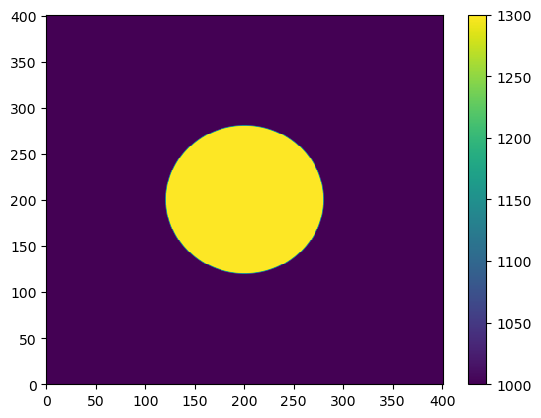

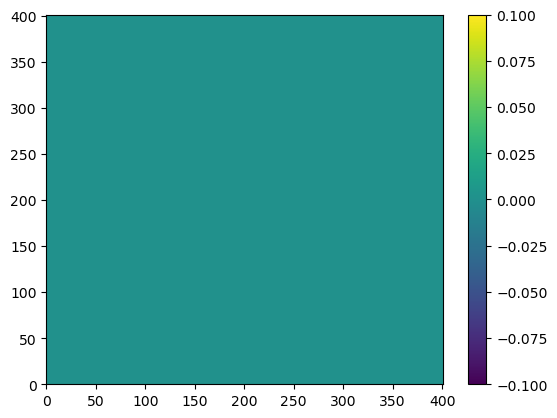

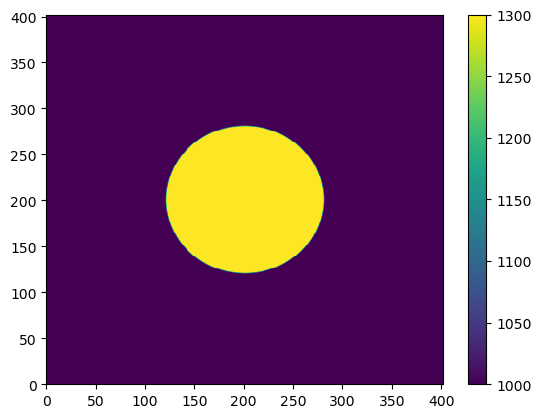

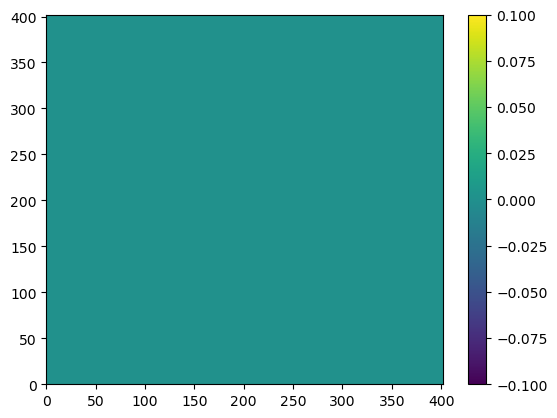

In [20]:
# NOTE - this code was for testing marker interpolation routine optimizations.
include("Markers.jl")
nx = 401
ny = nx
markx=10
marky=10
W = 5e5
H = 5e5

bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.

grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
println("Initial condition...")
initial_conditions!(markers)

tmp1, = marker_to_stag( markers,grid,markers.scalars[1:1,:],"basic")
@time tmp1, = marker_to_stag( markers,grid,markers.scalars[1:1,:],"basic")
tmp2, = marker_to_stag( markers,grid,["T",],"basic")
@time tmp2, = marker_to_stag( markers,grid,["T",],"basic")

figure()
pcolormesh(tmp1)
colorbar()
show()

figure()
pcolormesh(tmp2-tmp1)
colorbar()
show()


tmp1, = marker_to_stag( markers,grid,markers.scalars[1:1,:],"center")
@time tmp1, = marker_to_stag( markers,grid,markers.scalars[1:1,:],"center")

tmp2, = marker_to_stag( markers,grid,["T",],"center")
@time tmp2, = marker_to_stag( markers,grid,["T",],"center")

figure()
pcolormesh(tmp1)
colorbar()
show()

figure()
pcolormesh(tmp2-tmp1)
colorbar()
show()

# Timing/Performance

The cell below runs a single timestep at a specified resolution. It was useful for figuring out why certain parts of the code were extremely slow. It was also extremely helpful to use Julia's Profile.jl package to profile specifiec subroutines.

In [27]:
function single_timestep(ny,nx)
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0

    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.

    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 1e5*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);
    # fill!(rho,3200.);
    # fill!(kThermal,3.0);
    # fill!(Cp,1000.);

    time = 0.0
    iout=0
    last_plot = 0.0


    local rho
    local rhox
    local rhoy
    local eta_s
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast


    # Get density and viscosity from the markers.
    rho_new,eta_s_new = marker_to_stag(markers,grid,["rho","eta"],"basic");
    rhox_new, = marker_to_stag(markers,grid,["rho",],"vx")
    rhoy_new, = marker_to_stag(markers,grid,["rho",],"vy")

    rho   = copy(rho_new)
    rhox  = copy(rhox_new)
    rhoy  = copy(rhoy_new)
    eta_s = copy(eta_s_new) 

    eta_n = viscosity_to_cell_centers(grid,eta_s_new)

    # assemble and solve the stokes equations
    L,R = form_stokes(grid,eta_s,eta_n,rhox,rhoy,bc,gx,gy)
    solution = L\R
    vx,vy,P = unpack(solution,grid;ghost=true)
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)

    # get temperature at cell centers
    Tlast, = marker_to_stag(markers,grid,["T",],"center")
    Tlast = ghost_temperature(grid,Tlast);
    if time > 0.0
        nanind = findall(isnan.(Tlast))
        Tlast[nanind] = T[nanind]
    end

    dTmax = Inf
    while dTmax >= 20.0 # limit maximum temperature change
        # assemble and solve the energy equation
        println("Trying with timestep ",dt)
        L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt);
        Tnew = L\R;
        Tnew = reshape(Tnew,grid.ny,grid.nx);
        Tnew = ghost_temperature(grid,Tnew);

        T = copy(Tnew)

        dTemp = Tnew-Tlast
        # compute the maximum temperature change
        dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
        println("dTmax=",dTmax," dt=",dt)
        dt = min(dt,dTmax < 20.0 ? dt : dt/2)
    end

    dT_subgrid_node = subgrid_temperature_relaxation!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
    dT_remaining = dTemp - dT_subgrid_node
    cell_center_change_to_markers!(markers,grid,dT_remaining,"T")


    move_markers_rk2!(markers,grid,vx,vy,dt)
    return markers,grid,vx,vy,dt
    time += dt
end

@time markers,grid,vx,vy,dt = single_timestep(401,401)
@time move_markers_rk2!(markers,grid,vx,vy,dt)

Creating Markers...
  0.013561 seconds (19 allocations: 265.504 MiB)
Initial condition...
  0.095697 seconds
Trying with timestep 2.1605658041362323e11
dTmax=20.03084297156829 dt=2.1605658041362323e11
Trying with timestep 1.0802829020681161e11
dTmax=11.609558957949048 dt=1.0802829020681161e11
  5.045736 seconds (1.52 k allocations: 4.242 GiB, 0.28% gc time)
  0.250386 seconds (219 allocations: 749.652 MiB, 7.21% gc time)
